In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import pmdarima.arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('Impute_misvalues_hungyen.csv')
df

,Date,Hour,Waterlevel
0,1/1/2008,0,47.0
1,1/1/2008,1,43.0
2,1/1/2008,2,40.0
3,1/1/2008,3,37.0
4,1/1/2008,4,34.0
...,...,...,...
64056,4/23/2015,0,127.0
64057,4/23/2015,1,124.0
64058,4/23/2015,2,120.0
64059,4/23/2015,3,115.0


In [3]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [4]:
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,00:00:00,47.0
1,1/1/2008,01:00:00,43.0
2,1/1/2008,02:00:00,40.0
3,1/1/2008,03:00:00,37.0
4,1/1/2008,04:00:00,34.0


In [5]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


In [6]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size].iloc[:, [-1]], df[train_size:].iloc[:, [-1]]


Text(0, 0.5, 'Waterlevel')

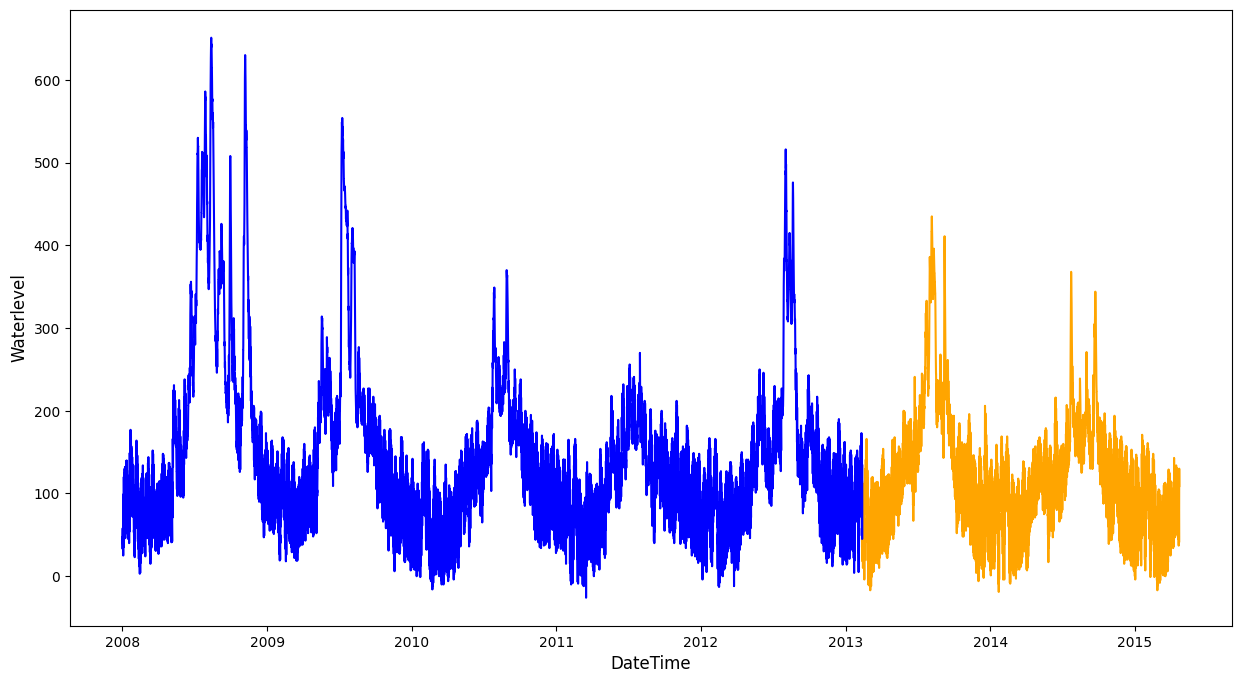

In [7]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['Waterlevel'], label = "test", color = 'orange')
plt.plot(train.index, train['Waterlevel'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)

In [8]:
train_data = train.values
test_data = test.values
timesteps=45
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
 

In [9]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(44798, 44) (44798, 1)
(19175, 44) (19175, 1)


In [10]:
warnings.filterwarnings(category=UserWarning, action='ignore')
arima_model = pmdarima.arima.auto_arima(train_data, seasonal=False, 
                                        error_action='ignore', trace=True,
                                        suppress_warnings=True, maxiter=20, stepwise=True,
                                        n_jobs=2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=200980.726, Time=16.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=289610.714, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216400.279, Time=1.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248451.402, Time=3.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=289608.719, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=207092.816, Time=5.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=201845.967, Time=13.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=201859.951, Time=15.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=200607.340, Time=18.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=206436.578, Time=8.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=200572.517, Time=18.18 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=200280.772, Time=22.15 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=20.81 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=200378.544, Time=24.19 sec
 ARI

In [11]:
arima_model.fit(train_data)

ARIMA(maxiter=20, order=(5, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
test_data.shape

(19219, 1)

In [13]:
train_data.shape

(44842, 1)

In [14]:
predictions_train_arima = arima_model.predict(start=0, end=len(train_data)-1,n_periods = len(train_data))
n_periods_test = len(test_data)  # or any integer value you want to use
predictions_test_arima = arima_model.predict(n_periods=n_periods_test)

In [15]:
predictions_train_arima

array([135.96263284, 134.36120331, 130.62252615, ...,  97.25575895,
        97.25575895,  97.25575895])

In [16]:
predictions_test_arima

array([135.96263284, 134.36120331, 130.62252615, ...,  97.25575895,
        97.25575895,  97.25575895])

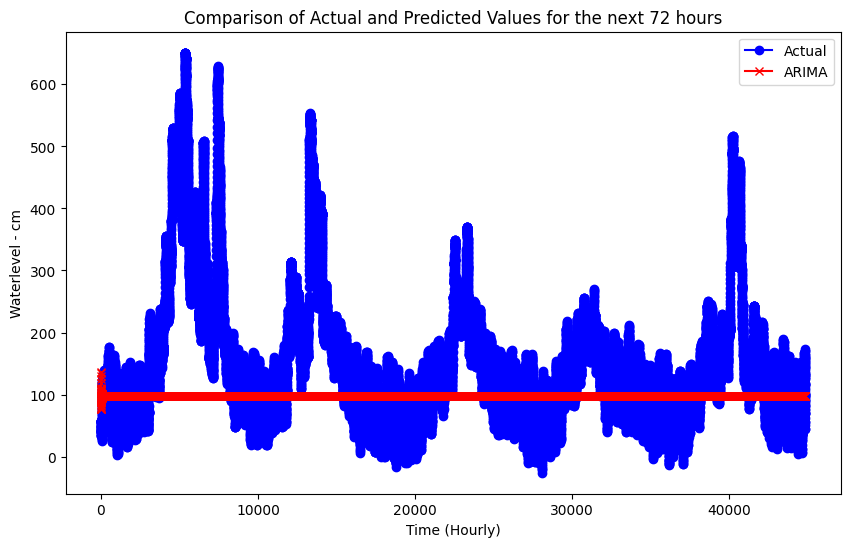

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(train_data[:], label='Actual', color='blue', marker='o')
plt.plot(predictions_train_arima[:], label='ARIMA', color='red', marker='x')

plt.title(f'Comparison of Actual and Predicted Values for the next {hours} hours')
plt.xlabel('Time (Hourly)')
plt.ylabel('Waterlevel - cm')
plt.legend()


plt.show()

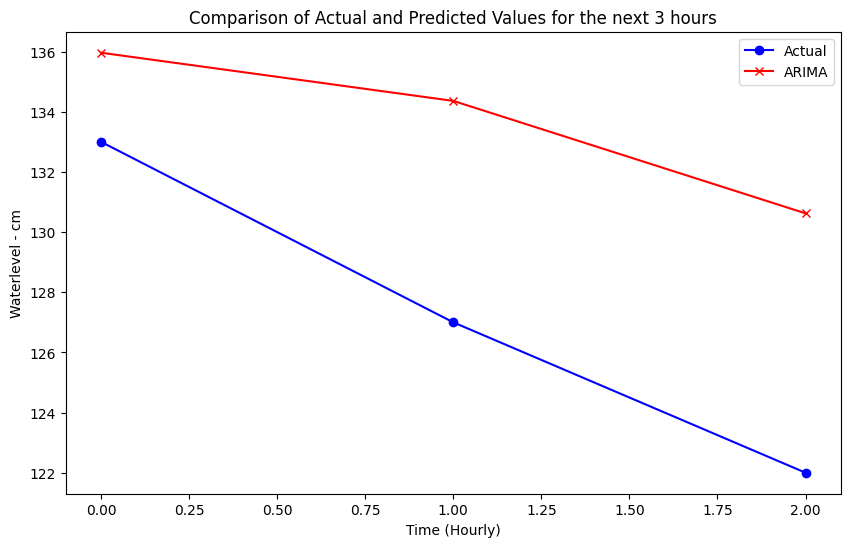

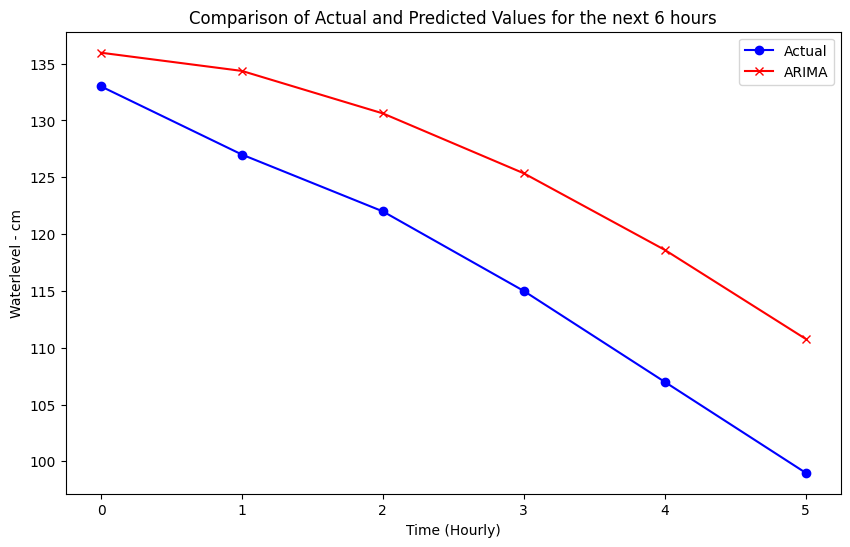

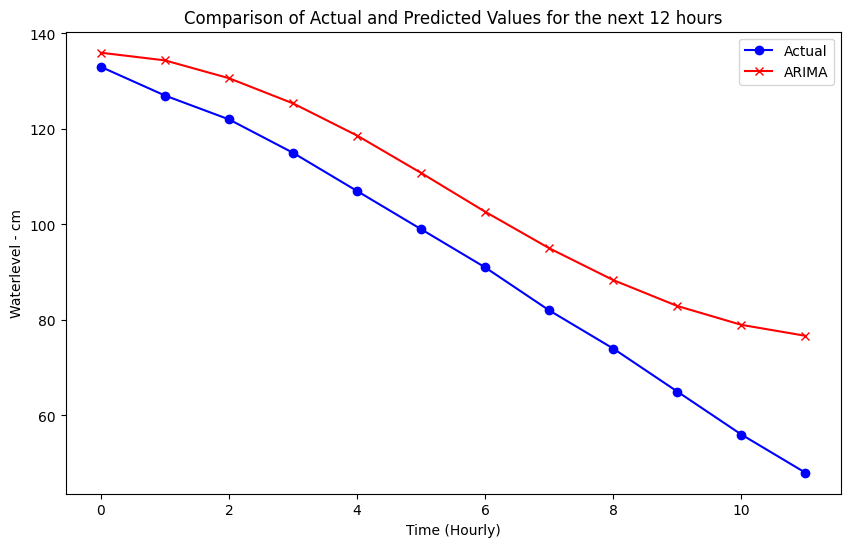

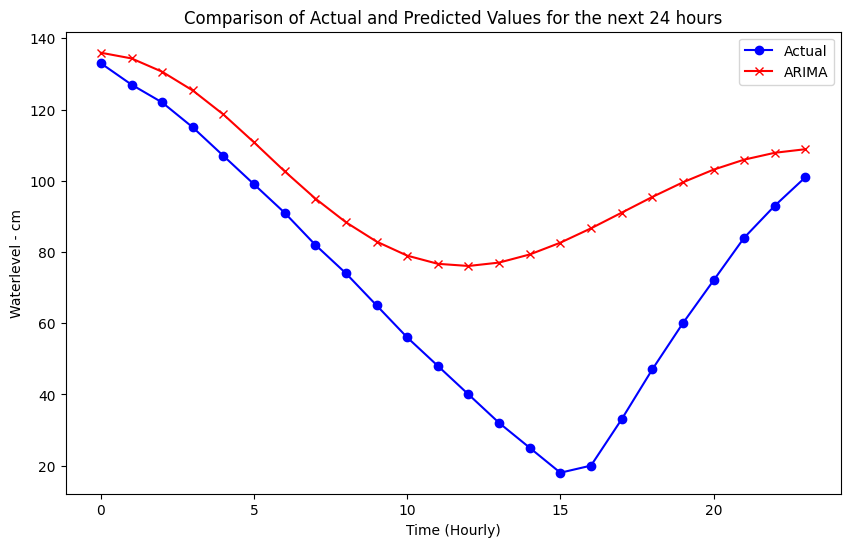

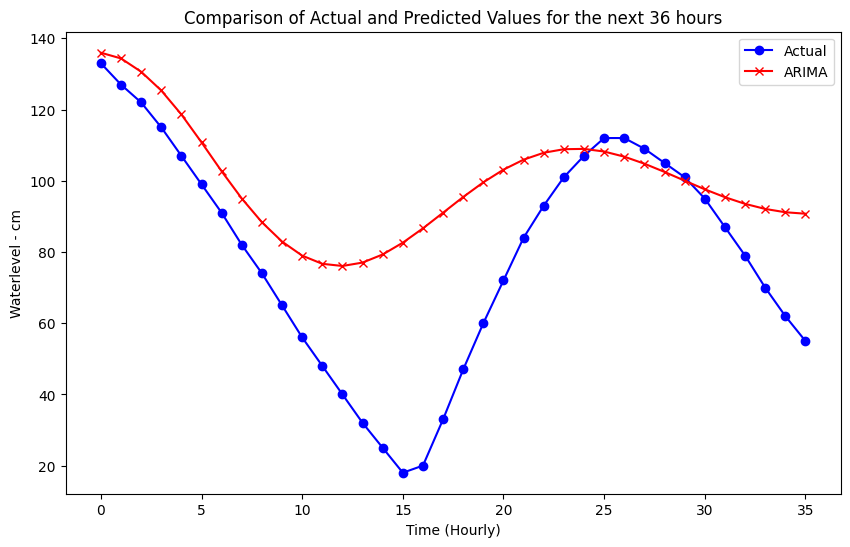

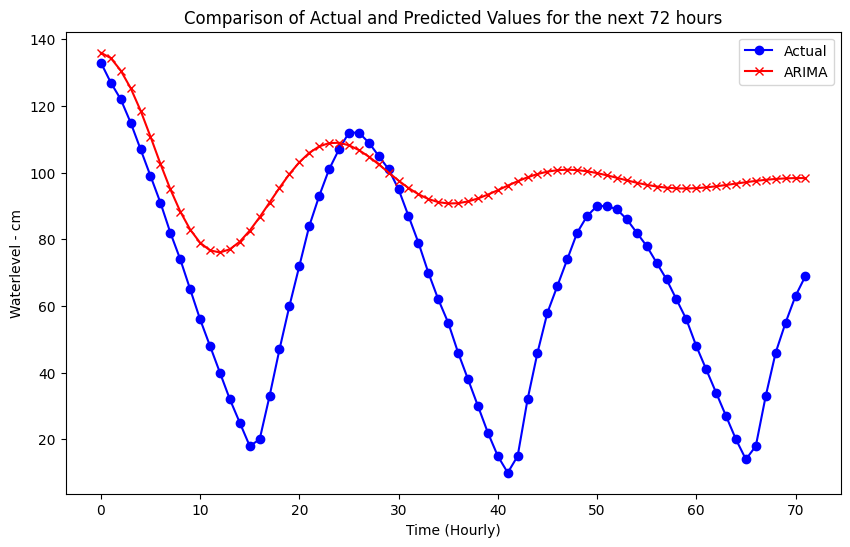

In [18]:
time_forecast = [3,  6, 12, 24, 36, 72]
for hours in time_forecast:
    plt.figure(figsize=(10, 6))
    
    plt.plot(test_data[:hours], label='Actual', color='blue', marker='o')
    plt.plot(predictions_test_arima[:hours], label='ARIMA', color='red', marker='x')

    plt.title(f'Comparison of Actual and Predicted Values for the next {hours} hours')
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Waterlevel - cm')
    plt.legend()


    plt.show()

In [20]:
predictions_arima = np.concatenate([predictions_train_arima, predictions_test_arima])

predictions_arima.shape

(64061,)

In [21]:
residuals_test = test_data.flatten() - predictions_test_arima
residuals_test.shape

(19219,)

In [22]:
residuals_train = train_data.flatten() - predictions_train_arima
residuals_train.shape

(44842,)

In [23]:
residuals = np.concatenate([residuals_train, residuals_test])
residuals.shape

(64061,)

In [24]:
df_ARIMA = pd.DataFrame({'Actual': df['Waterlevel'], 
                   'Predictions_ARIMA': predictions_arima,
                   'Residuals': residuals}, 
                   index=df.index)
df_ARIMA


,Actual,Predictions_ARIMA,Residuals
DateTime,,,
2008-01-01 00:00:00,47.0,135.962633,-88.962633
2008-01-01 01:00:00,43.0,134.361203,-91.361203
2008-01-01 02:00:00,40.0,130.622526,-90.622526
2008-01-01 03:00:00,37.0,125.353108,-88.353108
2008-01-01 04:00:00,34.0,118.616776,-84.616776
...,...,...,...
2015-04-23 00:00:00,127.0,97.255759,29.744241
2015-04-23 01:00:00,124.0,97.255759,26.744241
2015-04-23 02:00:00,120.0,97.255759,22.744241


## Model 2